In [45]:
import numpy as np
import datetime as dt
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from import_sql import *

## Run Parameters

In [46]:
recreate_base_tables=False
#rolling window
n=12
# params to group by
dims=['ACCOUNT_CLASS',
        'FIRST_PRODUCT_CATEGORY',
        # 'PS_INDICATOR',
        'COHORT_YM',
        'COUNTRY'
]

In [47]:
if recreate_base_tables:
    # create table of fees from MP. SQL from Temma
    create_sf_table(create_kpi_mp_fee_text)
    # create table of KPI base, no summarization
    create_sf_table(create_kpi_base_text)
    # create dimension table for ease of joins
    ## don't need if analyzing in pandas
    create_sf_table(create_kpi_dim_text)

In [48]:
# get the data at a month, account class, product, cohort year, country level
kpi_b = get_sf_data('SELECT * FROM PROD_ANALYTICS.PRODUCT_ANALYTICS.KPI_BASE')
kpi_b['ACTIVITY_DATE'] = pd.to_datetime(kpi_b['ACTIVITY_DATE'])
kpi_b['FIRST_CLOSEDATE'] = pd.to_datetime(kpi_b['FIRST_CLOSEDATE'])

Table Fetched


In [49]:
# Sort the data by 'accountid' and 'activity_date'
data_filtered = kpi_b.sort_values(by=['ACCOUNTID', 'ACTIVITY_DATE'])

In [50]:
# Calculate the return intervals
data_filtered['previous_activity_date'] = data_filtered.groupby('ACCOUNTID')['ACTIVITY_DATE'].shift(1)
data_filtered['return_interval'] = (data_filtered['ACTIVITY_DATE'] - data_filtered['previous_activity_date']).dt.days
# Drop the first transaction of each customer where return interval will be NaT
data_filtered.dropna(subset=['return_interval'], inplace=True)

In [51]:
# remove those that never returned
data_filtered=data_filtered.query('return_interval>0')

In [52]:
# Calculate average and median return intervals
average_return_interval = data_filtered['return_interval'].mean()
median_return_interval = data_filtered['return_interval'].median()
print(f"Average Return Interval: {average_return_interval} days")
print(f"Median Return Interval: {median_return_interval} days")

Average Return Interval: 31.2580035291152 days
Median Return Interval: 3.0 days


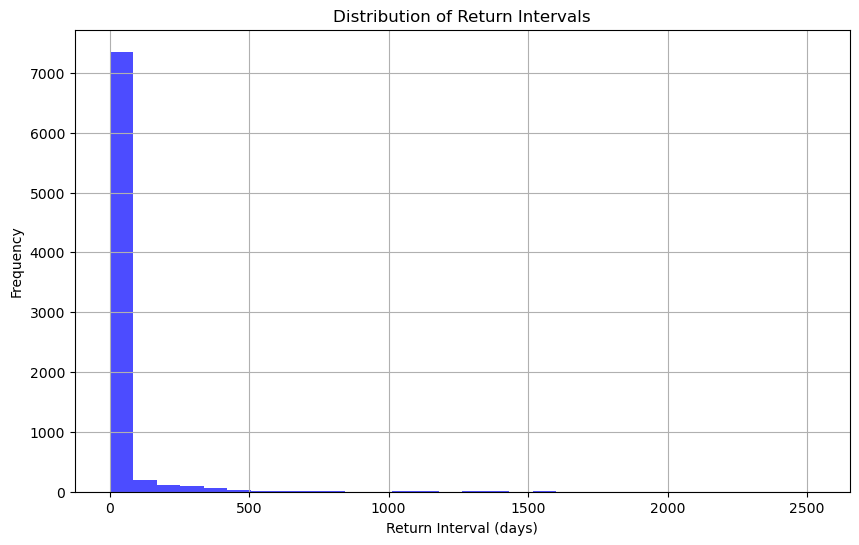

In [53]:
# Create a histogram of the return intervals
plt.figure(figsize=(10, 6))
plt.hist(data_filtered['return_interval'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Return Intervals')
plt.xlabel('Return Interval (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Do this by product category

In [54]:
# Sort the data by 'accountid' and 'activity_date'
data_filtered = kpi_b.sort_values(by=['ACCOUNTID','PRODUCT_LABEL_CATEGORY','ACTIVITY_DATE'])

In [55]:
# Calculate the return intervals
data_filtered['previous_activity_date'] = data_filtered.groupby(['ACCOUNTID','PRODUCT_LABEL_CATEGORY'])['ACTIVITY_DATE'].shift(1)
data_filtered['return_interval'] = (data_filtered['ACTIVITY_DATE'] - data_filtered['previous_activity_date']).dt.days
# Drop the first transaction of each customer where return interval will be NaT
data_filtered.dropna(subset=['return_interval'], inplace=True)

In [56]:
# remove those that never returned
data_filtered=data_filtered.query('return_interval>0')

In [57]:
data_filtered.groupby('PRODUCT_LABEL_CATEGORY').return_interval.agg({'mean','median','count'})

,count,mean,median
PRODUCT_LABEL_CATEGORY,,,
OTHER,731,4.298222,1.0
PRESEASON,297,214.622896,191.0
QP,5035,16.588679,3.0
TRADING ONLY,1611,37.642458,4.0


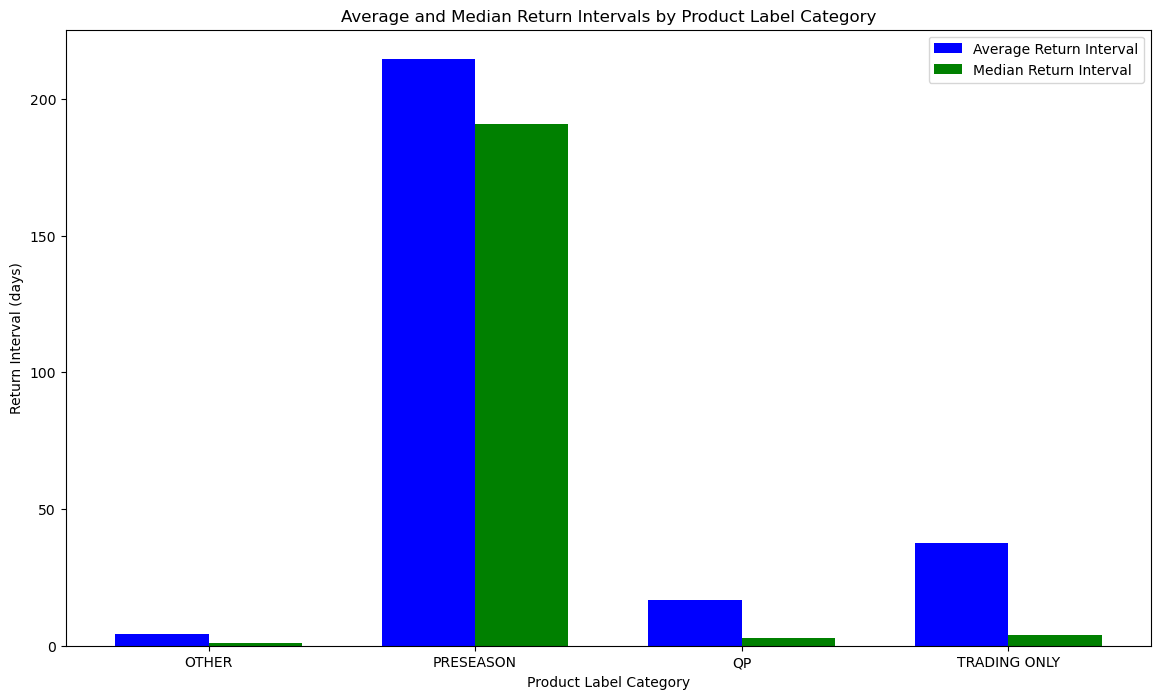

In [58]:
# Select relevant columns and rename them for clarity, including product label category
data_filtered = kpi_b[['ACCOUNTID', 'ACTIVITY_DATE', 'PRODUCT_LABEL_CATEGORY']].rename(
    columns={'ACCOUNTID': 'accountid', 'ACTIVITY_DATE': 'activity_date', 'PRODUCT_LABEL_CATEGORY': 'product_label_category'}
)

# Convert 'activity_date' to datetime
# data_filtered['activity_date'] = pd.to_datetime(data_filtered['activity_date'])

# Sort the data by 'accountid', 'product_label_category', and 'activity_date'
data_filtered = data_filtered.sort_values(by=['accountid', 'product_label_category', 'activity_date'])

# Calculate the return intervals
data_filtered['previous_activity_date'] = data_filtered.groupby(['accountid', 'product_label_category'])['activity_date'].shift(1)
data_filtered['return_interval'] = (data_filtered['activity_date'] - data_filtered['previous_activity_date']).dt.days

# Drop the first transaction of each customer where return interval will be NaT
data_filtered.dropna(subset=['return_interval'], inplace=True)

data_filtered=data_filtered.query('return_interval>0.0')

# Calculate average and median return intervals for each product category
grouped_data = data_filtered.groupby('product_label_category')['return_interval']
average_return_interval = grouped_data.mean()
median_return_interval = grouped_data.median()

# Convert to DataFrame for plotting
average_df = average_return_interval.reset_index()
median_df = median_return_interval.reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.35
index = range(len(average_df))

bar1 = ax.bar(index, average_df['return_interval'], bar_width, label='Average Return Interval', color='blue')
bar2 = ax.bar([p + bar_width for p in index], median_df['return_interval'], bar_width, label='Median Return Interval', color='green')

ax.set_xlabel('Product Label Category')
ax.set_ylabel('Return Interval (days)')
ax.set_title('Average and Median Return Intervals by Product Label Category')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(average_df['product_label_category'])
ax.legend()

plt.show()